# Bayesian estimation supersedes the t-test

This notebook illustrates how to do Bayesian Estimation of the difference between two independent distributions of normally distributed data that may contain outliers. It is based on a paper by <a href="http://www.indiana.edu/~kruschke/BEST/">John K. Kruschke: "Bayesian estimation supersedes the t test"</a>.

The Python code used here has been adapted from an <a href="https://github.com/strawlab/best">initial version by Andrew Straw</a>.

To do Markov-Chain Monte Carlo sampling in Python we use <a href="https://pymc-devs.github.io/pymc/">the PyMC package</a>.

In [1]:
%matplotlib inline
from __future__ import division
import pymc as pymc
import numpy as np
from bestplot import plot_posterior, plot_data_and_prediction, plot_data
import matplotlib.pyplot as plt
from IPython.display import display, HTML

display(HTML(open('Notebook.css').read()))  #load the CCS style sheet

Let's define some data:

In [2]:
# group 1
name1 = 'Group1'
y1 = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
       109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
       96,103,124,101,101,100,101,101,104,100,101])
       
# group 2
name2 = 'Group2'
y2 = np.array([99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
       104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
       101,100,99,101,100,102,99,100,99])


Now, let's have a look at the two distributions:

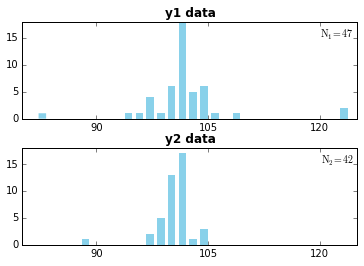

In [3]:
n_bins = 30
y = np.concatenate((y1,y2))
bins = np.linspace(np.min(y),np.max(y),n_bins)
ax = plt.subplot(2,1,1)
plot_data(y1, ax, bins = bins, group = 1, name = 'y1')
ax = plt.subplot(2,1,2)
plot_data(y2, ax, bins = bins, group = 2, name = 'y2')
plt.subplots_adjust(hspace=0.3)

This data looks like it is fairly normally distributed, but it clearly contains outliers. In order to deal with this, we model the data as a t-distribution characterised by a mean, $\mu$, a standard deviation, $\sigma$, and a normality parameter, $\nu$. The normality parameter makes the distribution more Normal if $\nu$ is large (over 30), and gives it bigger tails if $\nu$ gets closer to 1.

Since we do not know what the parameters are for each of the two data distributions, we need to estimate them from the data. To do this in a Bayesian framework, we will need to provide prior distributions that describe our beliefs about these parameters. This leads us to the following hierarchical model:

![](BESThist.jpg)

Here both data distributions (t-distributions) have independent distributions for their means and standard deviations, but share a single normality parameter, assuming outliers are equally likely in both distributions. The distribution for $\mu$ is a normal distribution with a mean equal to the mean of both sets of data, and a standard deviation 1000 times larger than that of the combined data:

In [4]:
y = np.concatenate((y1, y2))        # combine both groups
mu_m = np.mean(y)                   # mean of distribution of group means
mu_p = 1/(1000*np.std(y))**2        # precision of distribution of group means

The standard deviation, $\sigma$, of the data is modelled by a uniform distribution where all values between one thousands of the standard deviation of the data to one thousand times the standard deviation of the data are equally likely. This large range expresses that we are not very certain about the value $\sigma$:

In [5]:
sigma_low = np.std(y)/1000          # lower bound is 1000 times less than std of data
sigma_high = np.std(y)*1000         # upper bound is 1000 times more than std of data

Once these hyperparameters are chosen, we can define our prior distributions for the parameters of our model:

In [6]:
group1_mean = pymc.Normal('group1_mean', mu_m, mu_p)
group2_mean = pymc.Normal('group2_mean', mu_m, mu_p)
group1_std = pymc.Uniform('group1_std', sigma_low, sigma_high)
group2_std = pymc.Uniform('group2_std', sigma_low, sigma_high)
nu_minus_one = pymc.Exponential('nu_minus_one', 1/29)

To use these randomly sampled parameters to describe a t-distribution that fits the data, we need to modify the random variables in a deterministic manner. Our prior distribution actually specifies $\nu - 1$, so we need to add $1$, and the standard deviations need to be converted to a rate, $\lambda = 1/\sigma^2$:

In [7]:
# Normality nu = nu_minus_one + 1 
@pymc.deterministic(plot = False)
def nu(n = nu_minus_one):  
    out = n+1
    return out

# Scale lam1 = 1/std**2
@pymc.deterministic(plot=False)
def lam1(s = group1_std):
    out = 1/s**2
    return out

# Scale lam2 = 1/std**2    
@pymc.deterministic(plot=False)
def lam2(s = group2_std):
    out = 1/s**2
    return out

Now we are finally ready to define the data distributions - the lowest part in the hierarchy:

In [8]:
group1 = pymc.NoncentralT('group1', group1_mean, lam1, nu, value = y1, observed = True)
group2 = pymc.NoncentralT('group2', group2_mean, lam2, nu, value = y2, observed = True)

With all the distributions in the hierarchy defined, we can collect them in a PyMC Model, and initialise it for MCMC sampling:

In [9]:
model = pymc.Model({group1, group2, 
                    group1_mean, group2_mean, 
                    group1_std, group2_std, 
                    nu_minus_one})

# Define the MCMC object on the model
M = pymc.MCMC(model)

Now we can sample from the MCMC object using a Markov chain that is 'iter' long. The first 'burn' samples from this chain are discarded. Every 'thin'th sample from the remainder is kept and the rest discarded.

In [10]:
M.sample(iter = 110000, burn = 10000, thin = 1) 

 [-----------------100%-----------------] 110000 of 110000 complete in 27.0 sec

After running this, our estimation is done. We now get the estimated means and standard deviations for both sets of data and compute their differences. We also fix the bins for plotting the histogram to be the same for both sets of data, to show them on the same horizontal axis.

In [11]:
# Get the posterior distributions of the means and their difference
posterior_mean1 = M.trace('group1_mean')[:]
posterior_mean2 = M.trace('group2_mean')[:]
diff_means = posterior_mean1 - posterior_mean2

# Calculate common bin edges for both posteriors
posterior_means = np.concatenate((posterior_mean1, posterior_mean2))
bin_edges_means = np.linspace( np.min(posterior_means), np.max(posterior_means), n_bins )

In [12]:
# Get the posteriaor distributions of the std and their difference
posterior_std1 = M.trace('group1_std')[:]
posterior_std2 = M.trace('group2_std')[:]
diff_stds = posterior_std1 - posterior_std2

# Calculate common bin edges for both posteriors
posterior_stds = np.concatenate((posterior_std1, posterior_std2))
bin_edges_stds = np.linspace(np.min(posterior_stds), np.max(posterior_stds), n_bins)

We also calculate the effect size for the difference of the means, and convert the $\nu$ parameter to a log scale:

In [13]:
# Calculate effect size
effect_size = diff_means/np.sqrt((posterior_std1**2 + posterior_std2**2)/2)

In [14]:
# Get the distribution of the normality parameter
post_nu_minus_one = M.trace('nu_minus_one')[:]
# and convert to log10 scale
lognu = np.log10(post_nu_minus_one + 1)

Finally we define 10 subplots that we plot using the routines provided in the bestplot.py file.

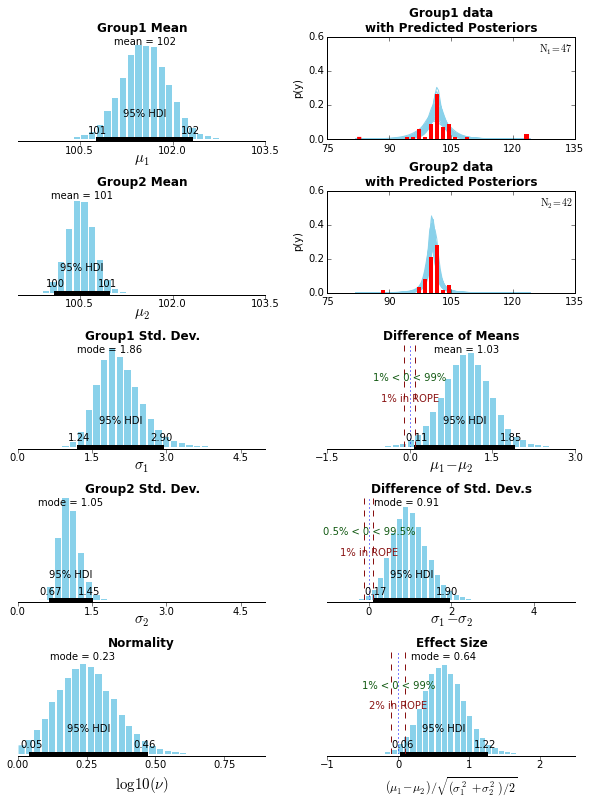

In [16]:
# Create a figure to hold 5 rows and 2 columns
f = plt.figure(figsize = (9,12), facecolor = 'white')

# Left column, top two: plot the distribution of the means
ax1 = f.add_subplot(5, 2, 1, axisbg = 'none')
plot_posterior( posterior_mean1, 
                ax = ax1, 
                bins = bin_edges_means, 
                title = name1 + ' Mean', 
                label = r'$\mu_1$',
                ctd = 'mean',
                printstats = False
              )

ax3 = f.add_subplot(5, 2, 3, axisbg = 'none')
plot_posterior( posterior_mean2, 
                ax = ax3, 
                bins = bin_edges_means,
                title = name2 + ' Mean', 
                label = r'$\mu_2$', 
                ctd = 'mean', 
                printstats = False
              )

# Left column, next two: plot the distribution of the stds
ax5 = f.add_subplot(5, 2, 5, axisbg = 'none')
plot_posterior( posterior_std1, 
                ax = ax5, 
                bins = bin_edges_stds,
                title = name1 + ' Std. Dev.', 
                label = r'$\sigma_1$', 
                ctd = 'mode', 
                printstats = False
              )

ax7 = f.add_subplot(5, 2, 7, axisbg = 'none')
plot_posterior( posterior_std2, 
                ax = ax7, 
                bins = bin_edges_stds,
                title = name2 + ' Std. Dev.',
                label = r'$\sigma_2$', 
                ctd = 'mode', 
                printstats = False
              )

# Left column, bottom row: Plot log10(nu)
ax9 = f.add_subplot(5, 2, 9, axisbg = 'none')
plot_posterior( lognu, 
                ax = ax9, 
                bins = n_bins,
                title = 'Normality',
                label = r'$\mathrm{log10}(\nu)$', 
                ctd = 'mode', 
                printstats = False
              )

#Right column, top two: plot histogram of data and 50 of the t-distribution fits from the MCMC chain
orig_vals = np.concatenate( (M.get_node('group1').value, M.get_node('group1').value) )
bin_edges = np.linspace( np.min(orig_vals), np.max(orig_vals), n_bins )
ax2 = f.add_subplot(5, 2, 2, axisbg = 'none')
plot_data_and_prediction( M.get_node('group1').value, 
                          posterior_mean1, 
                          posterior_std1,
                          post_nu_minus_one, 
                          ax2, 
                          bins = bin_edges, 
                          group = 1, 
                          name = name1, 
                        )

ax4 = f.add_subplot(5, 2, 4, axisbg = 'none', sharex = ax2, sharey = ax2)
plot_data_and_prediction( M.get_node('group2').value, 
                          posterior_mean2, 
                          posterior_std2,
                          post_nu_minus_one, 
                          ax4, 
                          bins = bin_edges, 
                          group = 2, 
                          name = name2, 
                        )

# Right column, third panel: plot the distribution of the differences of the means.
ax6 = f.add_subplot(5, 2, 6, axisbg = 'none')
plot_posterior( diff_means, 
                ax = ax6, 
                bins = n_bins,
                title = 'Difference of Means',
                label = r'$\mu_1 - \mu_2$',
                ctd = 'mean', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-0.1, 0.1], 
                printstats = False
              )

# Right column, fourth panel: plot the distribution of the differences of the stds.
ax8 = f.add_subplot(5, 2, 8, axisbg = 'none')
plot_posterior( diff_stds, 
                ax = ax8, 
                bins = n_bins,
                title = 'Difference of Std. Dev.s',
                label = r'$\sigma_1 - \sigma_2$',
                ctd = 'mode', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-0.1, 0.1], 
                printstats = False
              )

# Right column, bottom panel: plot the effect size
ax10 = f.add_subplot(5, 2, 10, axisbg = 'none')
plot_posterior( effect_size, 
                ax = ax10, 
                bins = n_bins,
                title = 'Effect Size',
                label = r'$(\mu_1 - \mu_2)/\sqrt{(\sigma_1^2 + \sigma_2^2)/2}$',
                ctd = 'mode', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-0.1, 0.1], 
                printstats = False
              )

f.subplots_adjust(hspace = 0.5, top = 0.92, bottom = 0.09,
                  left = 0.09, right = 0.95, wspace = 0.25)
